In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # put -1 to not use any

In [2]:
import math
import pandas as pd
import numpy as np 

import torch

import matplotlib.pyplot as plt
import SimpleITK as sitk

In [3]:
from nets.segmentation import *
from loaders.tt_dataset import TTDataModuleSeg, TrainTransformsSeg, EvalTransformsSeg
from callbacks.logger import SegImageLoggerNeptune, MaskRCNNImageLoggerNeptune


2025-09-11 14:11:25.371087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757614285.384279 1238790 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757614285.388363 1238790 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757614285.399738 1238790 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757614285.399752 1238790 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757614285.399754 1238790 computation_placer.cc:177] computation placer alr

In [4]:
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_test.csv')

seg_column='seg'
class_column='class'
img_column='img'
mount_point='/CMF/data/lumargot/trachoma/PoPP_Data/mtss'
drop_labels=['Reject', 'Short Incision']
concat_labels=['overcorrection', 'Gap', 'ECA', 'Fleshy']

In [5]:
train_transform = TrainTransformsSeg()
eval_transform = EvalTransformsSeg()


ttdata = TTDataModuleSeg(df_train, df_val, df_test, batch_size=1, num_workers=4, img_column=img_column, 
                          seg_column=seg_column, class_column=class_column, mount_point=mount_point, 
                          train_transform=train_transform, valid_transform=eval_transform, test_transform=eval_transform)




In [6]:
ttdata.setup()
ds = ttdata.test_ds
dl = ttdata.test_dataloader()

In [7]:
batch = next(iter(dl))

In [8]:
img,seg =  batch['img'], batch['seg']

In [9]:
from nets.segmentation import HybridEyelidClassifier

In [10]:
model = HybridEyelidClassifier(class_weights = [0,0,0])

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.


In [11]:
out = model.training_step(batch,0)

/tools/anaconda3/envs/tt/lib/python3.10/site-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [ ]:
from torchvision import models

In [ ]:
effnet = models.efficientnet_b0(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
conv2d = effnet.features[0]
encod_layer1 = effnet.features[1]
norm_layer1 = nn.InstanceNorm2d(16, affine=True)

encod_layer2 = effnet.features[2]
norm_layer2 = nn.InstanceNorm2d(24, affine=True)

encod_layer3 = effnet.features[3]
norm_layer3 = nn.InstanceNorm2d(40, affine=True)


In [ ]:
from torchvision.transforms import Resize

transform_layer1 = Resize(size=(384, 768))
transform_layer2 = Resize(size=(192, 384))
transform_layer3 = Resize(size=(96, 192))

In [ ]:
list_layers = [ effnet.features[i] for i in range(4,9) ]
decoder = nn.Sequential(*list_layers)

In [ ]:
num_classes =3
fc = nn.Linear(1280, num_classes)

In [ ]:
## encoder block

x = effnet.features[0](img)

x = encod_layer1(x)
downsized_seg = transform_layer1(seg)
x = x + downsized_seg
x = norm_layer1(x)

x = encod_layer2(x)
downsized_seg = transform_layer2(seg)
x = x + downsized_seg
x = norm_layer2(x)

x = encod_layer3(x)
downsized_seg = transform_layer3(seg)
x = x + downsized_seg
x = norm_layer3(x)

x = decoder(x)


In [ ]:
classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(1280, num_classes)
)
pooling = nn.AdaptiveAvgPool2d(output_size=1)

In [ ]:
x_pooled = effnet.avgpool(x)
x_pooled = torch.flatten(x_pooled, 1)

In [ ]:
x_pooled.shape

torch.Size([1, 1280])

In [ ]:
classifier(x_pooled)

metatensor([[-0.1521,  0.0687, -0.1349]], grad_fn=<AliasBackward0>)

In [ ]:
effnet.classifier(x_pooled)

metatensor([[-3.6675e-01, -1.0212e-01, -2.5325e-01, -4.1064e-01, -1.1661e-01,
         -2.4088e-01,  1.1880e-01, -1.3237e-01,  3.9459e-02, -1.5477e-01,
         -3.5948e-01,  8.0078e-02, -5.8121e-02,  3.6314e-02, -3.7964e-01,
         -3.2090e-01, -1.6877e-01,  1.2970e-01, -3.9606e-01, -1.1980e-01,
         -1.2400e-01, -1.4895e-01, -3.5384e-01, -2.0728e-01,  1.1800e-01,
         -2.0400e-01, -3.7928e-01, -2.5680e-01, -1.9102e-01, -1.6304e-01,
          1.5884e-01, -1.4756e-02,  3.7017e-01, -3.2344e-01, -6.3781e-02,
         -2.9114e-02, -1.9497e-01, -1.0236e-01,  2.3910e-02, -3.6052e-01,
         -8.4605e-02,  2.7350e-02, -1.3850e-02,  4.6436e-02,  1.7302e-01,
         -1.6792e-01, -3.2402e-02,  2.3410e-02, -5.2663e-01,  1.5376e-01,
         -2.1032e-02,  2.2757e-01,  1.3461e-02, -2.3091e-02,  5.6212e-02,
         -4.6477e-02, -3.3081e-01, -2.1694e-03,  9.7170e-02,  1.0601e-01,
         -2.1393e-02, -1.3933e-01, -7.6209e-02, -6.2766e-01, -1.0907e-01,
         -3.9313e-01, -3.4083e-02,

In [ ]:
instance_norm = nn.InstanceNorm2d(16, affine=True)

In [ ]:
m(x).shape

torch.Size([1, 16, 384, 768])

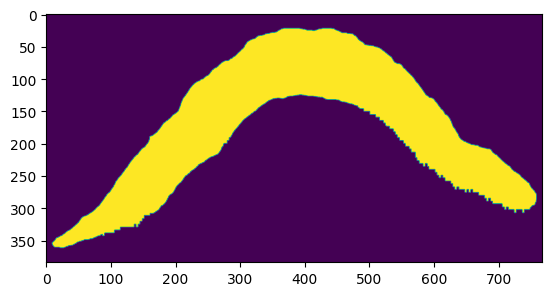

In [ ]:
plt.imshow(downsized_seg[0,0])
# plt.imshow(img[0].permute(1,2,0))